# Prediction of user's transportation mode (Kaggle)
## Author : Mateus C. Pedrino

This program will work on the prediction of user's transportation mode considering an IoT data set from Kaggle (https://www.kaggle.com/fschwartzer/tmd-dataset-5-seconds-sliding-window) and it will explore three classification methods : k nearest neighbors (KNN), bayesian classifier and Naive-Bayes classifier. All of these methods were tested under different setups and input data. This process will be clearer along this notebook, I hope you guys like it !

## Preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data=pd.read_csv('dataset_5secondWindow%5B1%5D.csv', header=(0))

data.head()

,time,android.sensor.accelerometer#mean,android.sensor.accelerometer#min,android.sensor.accelerometer#max,android.sensor.accelerometer#std,android.sensor.gyroscope#mean,android.sensor.gyroscope#min,android.sensor.gyroscope#max,android.sensor.gyroscope#std,sound#mean,sound#min,sound#max,sound#std,target
0,78.0,9.811476,9.758895,9.849411,0.014626,0.001651,0.000000,0.003533,0.000737,0.000000,0.000000,0.000000,0.000000,Still
1,145.0,9.939207,7.707437,17.146631,1.775944,0.036326,0.011669,0.059388,0.020290,89.200210,89.065143,89.335277,0.191013,Car
2,150.0,9.827178,9.804817,9.849262,0.011199,0.001525,0.000000,0.002609,0.000713,0.000000,0.000000,0.000000,0.000000,Still
3,105.0,9.673039,7.659674,12.304298,0.862553,0.036440,0.020463,0.052512,0.010553,87.470377,87.470377,87.470377,2.284186,Car
4,77.0,9.993466,8.965621,10.891645,0.504117,0.183202,0.020667,0.380875,0.098819,89.770732,89.770732,89.770732,0.006389,Car


In [3]:
# Drop NaN and duplicate data

print(data.shape) # data size before preprocessing

data=data.dropna() # or fillna() depending on the problem
data=data.drop_duplicates()

print(data.shape) # Size of data after preprocessing

(5893, 14)
(5893, 14)


Thus, once data size hasn't changed, there weren't duplicate and NaN data.

In [4]:
# Checking outliers through boxplots
xdata=data.drop(data.columns[-1],axis=1)
ydata=data[data.columns[-1]]

# Interquartile range
Q1 = xdata.quantile(0.25)
Q3 = xdata.quantile(0.75)
IQR = Q3 - Q1
v=1.5 # Pondering of IQR

# Remove outliers 
df_no_out_x=xdata[~((xdata < (Q1 - v * IQR)) | (xdata > (Q3 + v * IQR))).any(axis=1)]
df_no_out_y=ydata[~((xdata < (Q1 - v * IQR)) | (xdata > (Q3 + v * IQR))).any(axis=1)]

# Reset index in order to concat dfs
new_idxs=pd.RangeIndex(len(df_no_out_y.index))
df_no_out_x.index=new_idxs
df_no_out_y.index=new_idxs

df_no_out=pd.concat([df_no_out_x,df_no_out_y], axis=1)

df_no_out.shape

(2894, 14)

As it can be noticed in the new data shape, outliers removing through interquartile range method reduced significantilly the number of instances compared to the original data.

In [6]:
# Check if there is any else missing data : NaN, None, etc...

total = data.isnull().sum().sort_values(ascending=False)
print(total)

target                               0
sound#std                            0
sound#max                            0
sound#min                            0
sound#mean                           0
android.sensor.gyroscope#std         0
android.sensor.gyroscope#max         0
android.sensor.gyroscope#min         0
android.sensor.gyroscope#mean        0
android.sensor.accelerometer#std     0
android.sensor.accelerometer#max     0
android.sensor.accelerometer#min     0
android.sensor.accelerometer#mean    0
time                                 0
dtype: int64


Now it's possible to conclude that there is no more missing data in "data".

## Split data into training and test sets

This split will be done considering data with normalization, standardization and original data without any "preprocessing". To perform this split, it will be used 70% of data for training set and 30% for test set.

For now, dataset without outliers won't be analysed.

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

labels=list(data.columns) # Names of features
aux_data=data # In order to avoid changes in the original data frame
X=np.array(aux_data.drop(labels[-1], axis = 1))
Y=np.array(aux_data[labels[-1]],dtype=str)

# Standardization and Normalization
X_std=StandardScaler().fit_transform(X)
X_mm=MinMaxScaler().fit_transform(X)

# Split data into training and test datasets (70% and 30%, respectively)
p=0.7

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 1-p, random_state = 42)
train_x_std, test_x_std, train_y_std, test_y_std = train_test_split(X_std, Y, test_size = 1-p, random_state = 42)
train_x_mm, test_x_mm, train_y_mm, test_y_mm = train_test_split(X_mm, Y, test_size = 1-p, random_state = 42)

## KNN - k parameter, normalization, standardization and distance metrics effects in accuracy

The study of k parameter influence will be conducted taking into account data without normalization or standardization, with normalization and with standardization using each one of these distance metrics : euclidean, manhattan, chebyshev and minkowski.

In [9]:
from sklearn.neighbors import KNeighborsClassifier

kmin=1
kmax=15

dists=['euclidean','manhattan','chebyshev','minkowski'] # Minkowski must be the last one !

ps=[1.2,1.5,3] # Minkowski parameters

scr=[]
scr_std=[]
scr_mm=[]

for d in dists:
    if d!='minkowski':
        aux=[]
        aux_std=[]
        aux_mm=[]
        for k in range(kmin,kmax): 
            knn=KNeighborsClassifier(n_neighbors=k, metric=d)
            # Without normalization and standardization
            knn.fit(train_x,train_y)
            pred_y=knn.predict(test_x)
            aux.append(accuracy_score(pred_y,test_y))
            # Standardization
            knn.fit(train_x_std,train_y_std)
            pred_y_std=knn.predict(test_x_std)
            aux_std.append(accuracy_score(pred_y_std,test_y_std))
            # Normalization
            knn.fit(train_x_mm,train_y_mm)
            pred_y_mm=knn.predict(test_x_mm)
            aux_mm.append(accuracy_score(pred_y_mm,test_y_mm))
        scr.append(aux)
        scr_std.append(aux_std)
        scr_mm.append(aux_mm)
    # Exclude from here and remove "if" if minkowski isn't an interesting metric for you
    else:
        for j in ps:
            aux=[]
            aux_std=[]
            aux_mm=[]
            for k in range(kmin,kmax): 
                knn=KNeighborsClassifier(n_neighbors=k, metric=d,p=j)
                # Without normalization and standardization
                knn.fit(train_x,train_y)
                pred_y=knn.predict(test_x)
                aux.append(accuracy_score(pred_y,test_y))
                # Standardization
                knn.fit(train_x_std,train_y_std)
                pred_y_std=knn.predict(test_x_std)
                aux_std.append(accuracy_score(pred_y_std,test_y_std))
                # Normalization
                knn.fit(train_x_mm,train_y_mm)
                pred_y_mm=knn.predict(test_x_mm)
                aux_mm.append(accuracy_score(pred_y_mm,test_y_mm))
            scr.append(aux)
            scr_std.append(aux_std)
            scr_mm.append(aux_mm)            

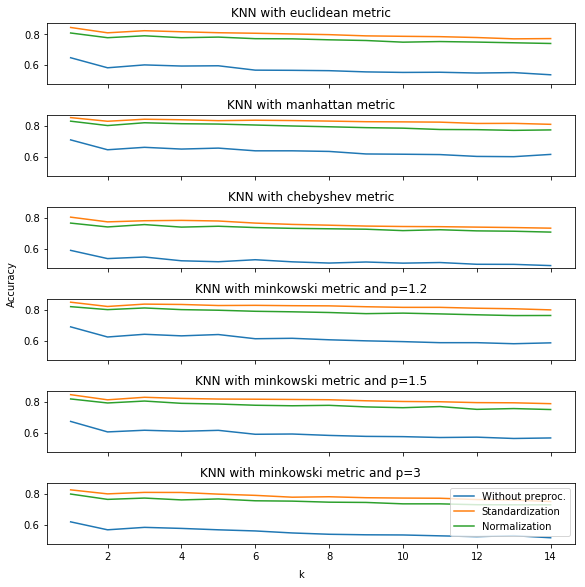

In [11]:
# Plots of knn results

kv=np.arange(kmin,kmax,1)

fig, ax = plt.subplots(len(dists)+len(ps)-1,1,sharex=True, sharey=True,figsize=(8, 8)) # -1 because minkowski is counted twice
for i in range(len(dists)):
    if dists[i]!='minkowski':
        ax[i].plot(kv,scr[i],label='Without preproc.')
        ax[i].plot(kv,scr_std[i],label='Standardization')    
        ax[i].plot(kv,scr_mm[i],label='Normalization')
        ax[i].set_title('KNN with '+dists[i]+' metric')
    else:
        for j in range(len(ps)):
            ax[i+j].plot(kv,scr[i+j],label='Without preproc.')
            ax[i+j].plot(kv,scr_std[i+j],label='Standardization')    
            ax[i+j].plot(kv,scr_mm[i+j],label='Normalization')
            ax[i+j].set_title('KNN with '+dists[i]+' metric and p='+str(ps[j]))

fig.text(0.5, -0.01, 'k', ha='center')
fig.text(-0.01, 0.5, 'Accuracy', va='center', rotation='vertical')
plt.legend()
plt.tight_layout()
plt.show()

As we can observe above, the best KNN results are the ones with standardization, and distance metric dindn't have a huge influence in accuracy results. However, the metric with best performance and less variation with k was manhattan.

Let's check if the classification is improved using data frame without outliers through interquartile method. For that it'll be used manhattan distance metric and data with standardization (best performance).

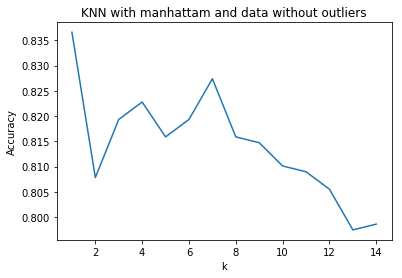

In [12]:
# Split data without outliers into training and test sets

aux_data=df_no_out # In order to avoid changes in the original data frame (no outliers)
X_no_out=np.array(aux_data.drop(labels[-1], axis = 1))
Y_no_out=np.array(aux_data[labels[-1]],dtype=str)

# Standardization
X_std_no_out=StandardScaler().fit_transform(X_no_out)

# Split data into training and test datasets (70% and 30%, respectively)
p=0.7

train_x_std_no_out, test_x_std_no_out, train_y_std_no_out, test_y_std_no_out = train_test_split(X_std_no_out, Y_no_out, test_size = 1-p, random_state = 42)

scr_no_out=[]

for k in range(kmin,kmax): 
    knn=KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn.fit(train_x_std_no_out,train_y_std_no_out)
    pred_y_std_no_out=knn.predict(test_x_std_no_out)
    scr_no_out.append(accuracy_score(pred_y_std_no_out,test_y_std_no_out))

import matplotlib.pyplot as plt

plt.figure()
plt.plot(kv,scr_no_out)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('KNN with manhattam and data without outliers')
plt.show()

## Bayesian classifier

Checking accuracy with bayesian classifier considering the 3 types of KNN tested data : normalization, standardization and without any of these former ones.

In [13]:
# Function to predict y with bayesian classifier

def bayes_classifier(train_x,train_y,test_x,classes):
    # Let's consider p(x|wi) as multivariate gaussian distribution (parametric approach)
    from scipy.stats import multivariate_normal
    # P matrix will contain the discriminant functions of each instance in x_test to belong to each wi class
    P=pd.DataFrame(np.zeros((test_x.shape[0],len(classes))),columns=classes)

    for i in range(len(classes)):
        elements=tuple(np.where(train_y==classes[i])) # rows that belongs to classes[i]
        Z = train_x[elements,:][0] # Z has now only elements of train_x that belongs to classes[i]
        m = np.mean(Z, axis = 0) # m has in each column mean of each variable of Z 
        cv=np.cov(np.transpose(Z)) # cov matrix of Z - transpose because cov must receive an input as x=[x1,x2,x3...]^T
        for j in range(test_x.shape[0]):
            x=test_x[j,:]
            pj=multivariate_normal.pdf(x,mean=m,cov=cv)
            P[classes[i]][j]=pj
    
    # Now, we'll have to check which collumn of P has the biggest value for each P row and 
    # than consider the biggest value as the one that represent instance i class (row)

    pred_y=[]

    for i in range(P.shape[0]):
        row_P=np.array(P.iloc[[i]]) # each row of P
        c_idx=np.argmax(row_P) # index of the biggest value of each P row
        pred_y.append(classes[c_idx]) # convert class index to class label and append it to pred_y
        
    pred_y=np.array(pred_y, dtype=str) # convert list to array in order to compute accuracy right after
    return pred_y

# Name of each class

classes=pd.unique(data[data.columns[-1]]) # Extract class labels
classes=np.array(classes, dtype=str) # Convert to array

# Compute prediction array with bayesian classifier for each data type

# Prediction with bayesian classifier
pred_y_bc=bayes_classifier(train_x,train_y,test_x,classes)
pred_y_std_bc=bayes_classifier(train_x_std,train_y_std,test_x_std,classes)
pred_y_mm_bc=bayes_classifier(train_x_mm,train_y_mm,test_x_mm,classes)

# Compute accuracy
score_bc=accuracy_score(pred_y_bc,test_y)
score_mm_bc=accuracy_score(pred_y_mm_bc,test_y_mm)
score_std_bc=accuracy_score(pred_y_std_bc,test_y_std)

print('*********************')
print('Bayesian classifier')
print('*********************\n')
print('Accuracy without normalization : ',score_bc)
print('Accuracy with normalization : ',score_mm_bc)
print('Accuracy with normalization : ',score_std_bc)

*********************
Bayesian classifier
*********************

Accuracy without normalization :  0.6029411764705882
Accuracy with normalization :  0.6029411764705882
Accuracy with standardization :  0.6029411764705882


As we can notice it, accuracies with bayesian classifier were smaller than KNN accuracies and standardization and normalization invariant. It's important to highlight that <font color='red'>It wasn't possible to test bayesian classifier with data without outliers because the covariance matrix for this case isn't singular</font>.

## Naive -Bayes (NB) classifier


Checking accuracy with NB classifier considering the 3 types of KNN tested data : normalization, standardization and without any of these former ones. For NB classifier the following distributions will be tested :  gaussian (gnb), multinomial (mnb) and bernoulli (bnb).

In [14]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

# NB using univariate gaussian distribution. 
gnb=GaussianNB()
# Data without normalization and standardization
gnb.fit(train_x,train_y)
pred_y_gnb=gnb.predict(test_x)
scr_gnb=accuracy_score(pred_y_gnb,test_y)
# Data with standardization
gnb.fit(train_x_std,train_y_std)
pred_y_gnb_std=gnb.predict(test_x_std)
scr_gnb_std=accuracy_score(pred_y_gnb_std,test_y_std)
# Data with normalization
gnb.fit(train_x_mm,train_y_mm)
pred_y_gnb_mm=gnb.predict(test_x_mm)
scr_gnb_mm=accuracy_score(pred_y_gnb_mm,test_y_mm)

# Without ouliers and with standardization
gnb.fit(train_x_std_no_out,train_y_std_no_out)
pred_y_gnb_std_no_out=gnb.predict(test_x_std_no_out)
scr_gnb_std_no_out=accuracy_score(pred_y_gnb_std_no_out,test_y_std_no_out)

print('**************************************************')
print('Gaussian Naive-Bayes classifier with outliers')
print('**************************************************\n')
print('Accuracy without normalization : ',scr_gnb)
print('Accuracy with normalization : ',scr_gnb_mm)
print('Accuracy with standardization : ',scr_gnb_std)

print('\n**************************************************')
print('Gaussian Naive-Bayes classifier without outliers')
print('**************************************************\n')
print('Accuracy with standardization : ',scr_gnb_std_no_out)

# Multinomial NB -> only normalized data is possible (input must be positive because of log)
mnb=MultinomialNB()
# Normalization
mnb.fit(train_x_mm,train_y_mm)
pred_y_mnb_mm=mnb.predict(test_x_mm)
scr_mnb_mm=accuracy_score(pred_y_mnb_mm,test_y_mm)

print('\n**************************************************')
print('Multinomial Naive-Bayes classifier with outliers')
print('**************************************************\n')
print('Accuracy with normalization : ',scr_mnb_mm)

# Bernoulli NB
bnb=BernoulliNB()
# Data without normalization and standardization
bnb.fit(train_x,train_y)
pred_y_bnb=bnb.predict(test_x)
scr_bnb=accuracy_score(pred_y_bnb,test_y)
# Data with standardization
bnb.fit(train_x_std,train_y_std)
pred_y_bnb_std=bnb.predict(test_x_std)
scr_bnb_std=accuracy_score(pred_y_bnb_std,test_y_std)
# Data with normalization
bnb.fit(train_x_mm,train_y_mm)
pred_y_bnb_mm=bnb.predict(test_x_mm)
scr_bnb_mm=accuracy_score(pred_y_bnb_mm,test_y_mm)

# Without outliers and with standardization
bnb.fit(train_x_std_no_out,train_y_std_no_out)
pred_y_bnb_std_no_out=bnb.predict(test_x_std_no_out)
scr_bnb_std_no_out=accuracy_score(pred_y_bnb_std_no_out,test_y_std_no_out)

print('\n***********************************************')
print('Bernoulli Naive-Bayes classifier with outliers')
print('***********************************************\n')
print('Accuracy without normalization : ',scr_bnb)
print('Accuracy with normalization : ',scr_bnb_mm)
print('Accuracy with standardization : ',scr_bnb_std)

print('\n***********************************************')
print('Bernoulli Naive-Bayes classifier without outliers')
print('***********************************************\n')
print('Accuracy with standardization : ',scr_bnb_std_no_out)

**************************************************
Gaussian Naive-Bayes classifier with outliers
**************************************************

Accuracy without normalization :  0.5576923076923077
Accuracy with normalization :  0.5576923076923077
Accuracy with standardization :  0.5576923076923077

**************************************************
Gaussian Naive-Bayes classifier without outliers
**************************************************

Accuracy with standardization :  0.6098964326812428

**************************************************
Multinomial Naive-Bayes classifier with outliers
**************************************************

Accuracy with normalization :  0.5254524886877828

***********************************************
Bernoulli Naive-Bayes classifier with outliers
***********************************************

Accuracy without normalization :  0.27828054298642535
Accuracy with normalization :  0.27884615384615385
Accuracy with standardization :  0.548

Thus, as we can see, NB accuracy (regardless of the distribution) was the worst one until now and outliers removing increased a bit the performance. However, besides outliers removing increased NB performance, it's still worse than KNN.

## Data correlation

A correlation study will be performed among data features and all of the classification methods will be tested again for data with correlation coefficient less than 0.5. 

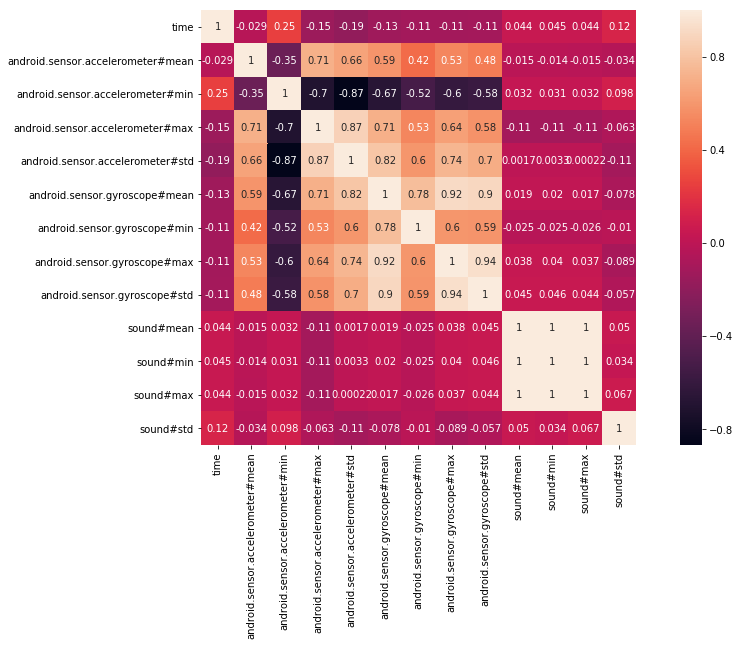

Features couples with correlation less than  0.5 :

 [['android.sensor.accelerometer#mean', 'android.sensor.accelerometer#max'], ['android.sensor.accelerometer#mean', 'android.sensor.accelerometer#std'], ['android.sensor.accelerometer#mean', 'android.sensor.gyroscope#mean'], ['android.sensor.accelerometer#mean', 'android.sensor.gyroscope#max'], ['android.sensor.accelerometer#min', 'android.sensor.accelerometer#max'], ['android.sensor.accelerometer#min', 'android.sensor.accelerometer#std'], ['android.sensor.accelerometer#min', 'android.sensor.gyroscope#mean'], ['android.sensor.accelerometer#min', 'android.sensor.gyroscope#min'], ['android.sensor.accelerometer#min', 'android.sensor.gyroscope#max'], ['android.sensor.accelerometer#min', 'android.sensor.gyroscope#std'], ['android.sensor.accelerometer#max', 'android.sensor.accelerometer#mean'], ['android.sensor.accelerometer#max', 'android.sensor.accelerometer#min'], ['android.sensor.accelerometer#max', 'android.sensor.accelerometer#std'], [

In [18]:
# Correlation matrix
import seaborn as sns

cormatrix=data.corr()
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(cormatrix, annot=True ,square=True)
plt.show()

# Features with correlation less than p
p = 0.5
var = []
for i in cormatrix.columns:
    for j in cormatrix.columns:
        if(i != j):
            if np.abs(cormatrix[i][j]) > p:
                var.append([i,j])

print('Features couples with correlation less than ',p,':\n\n', var)

print('\n Above present features names : \n\n',np.unique(var))

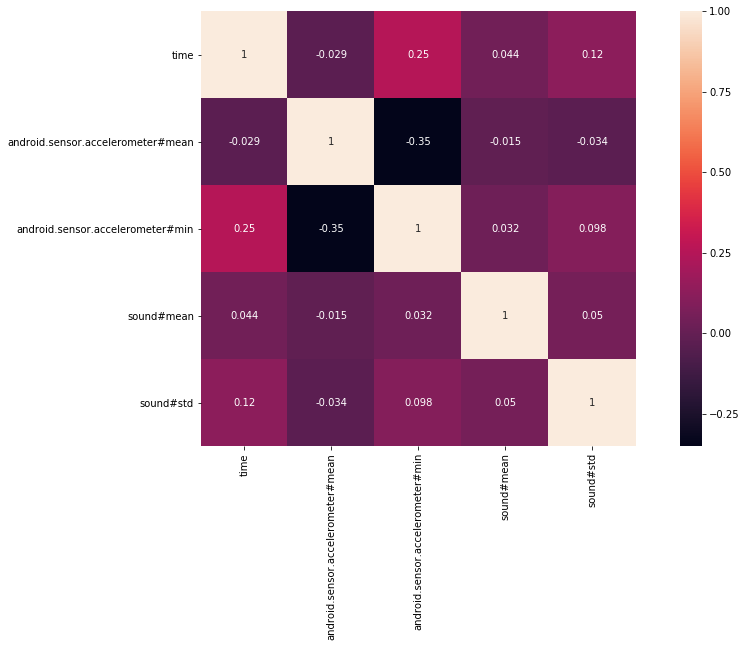

In [19]:
# Remove highly correlated features

# Superior 
# Upper triangular correlation matrix
upper = cormatrix.where(np.triu(np.ones(cormatrix.shape), k=1).astype(np.bool))

# Find indexes with correlation greater than cidx
cidx=0.5
to_drop = [column for column in upper.columns if any(abs(upper[column]) > cidx)]
# Drop features 
data_less_cor=data.drop(to_drop, axis=1)
cormatrix_less_cor=data_less_cor.corr()
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(cormatrix_less_cor, annot=True ,square=True)
plt.show()

In [20]:
# Test classifiers considering only less correlated features
labels_less_cor=list(data_less_cor.columns) # Nomes das variáveis
X_mc=np.array(data_less_cor.drop(labels_less_cor[-1], axis = 1))
X_mc_std=StandardScaler().fit_transform(X_mc)
Y_mc=np.array(data_less_cor[labels_less_cor[-1]],dtype=str)

# mc -> means less correlated (portuguese version)
p=0.7
train_x_mc, test_x_mc, train_y_mc, test_y_mc = train_test_split(X_mc_std, Y_mc, test_size = 1-p, random_state = 42)

# KNN
k=1
d='manhattan'
knn=KNeighborsClassifier(n_neighbors=k, metric=d)
# Without normalization and standardization
knn.fit(train_x_mc,train_y_mc)
pred_y_mc=knn.predict(test_x_mc)
scr_mc_knn=accuracy_score(pred_y_mc,test_y_mc)
print('Accuracy with KNN (manhattan and k=1) and data with |correlation|<',cidx,':\n\n',scr_mc_knn,'\n')

# Bayesian classifier
classes_mc=pd.unique(data_less_cor[labels_less_cor[-1]]) # Extrai o nome das classes
classes_mc=np.array(classes_mc, dtype=str) # Converte para vetor

pred_y_mc_bc=bayes_classifier(train_x_mc,train_y_mc,test_x_mc,classes_mc)
scr_mc_bc=accuracy_score(pred_y_mc_bc,test_y_mc)
print('Accuracy with bayesian classifier and data with |correlation|<',cidx,':\n\n',scr_mc_bc,'\n')

# Naive Bayes
# Gaussian
gnb.fit(train_x_mc,train_y_mc)
pred_y_mc_gnb=gnb.predict(test_x_mc)
scr_mc_gnb=accuracy_score(pred_y_mc_gnb,test_y_mc)
print('Accuracy with gaussian NB classifier and data with |correlation|<',cidx,':\n\n',scr_mc_gnb,'\n')

# Multinomial
# Normalized data (as explained before...)
X_mc_mm=MinMaxScaler().fit_transform(X_mc)
train_x_mc_mm, test_x_mc_mm, train_y_mc_mm, test_y_mc_mm = train_test_split(X_mc_mm, Y_mc, test_size = 1-p, random_state = 42)
mnb.fit(train_x_mc_mm,train_y_mc_mm)
pred_y_mc_mnb=mnb.predict(test_x_mc_mm)
scr_mc_mnb=accuracy_score(pred_y_mc_mnb,test_y_mc_mm)
print('Accuracy with Multinomial NB classifier and data with |correlation|<',cidx,':\n\n',scr_mc_mnb,'\n')

# Bernoulli
bnb.fit(train_x_mc,train_y_mc)
pred_y_mc_bnb=bnb.predict(test_x_mc)
scr_mc_bnb=accuracy_score(pred_y_mc_bnb,test_y_mc)
print('Accuracy with Bernoulli NB classifier and data with |correlation|<',cidx,':\n\n',scr_mc_bnb,'\n')



Accuracy with KNN (manhattan and k=1) and data with |correlation|< 0.5 :

 0.7782805429864253 

Accuracy with bayesian classifier and data with |correlation|< 0.5 :

 0.5531674208144797 

Accuracy with gaussian NB classifier and data with |correlation|< 0.5 :

 0.5299773755656109 

Accuracy with Multinomial NB classifier and data with |correlation|< 0.5 :

 0.36990950226244346 

Accuracy with Bernoulli NB classifier and data with |correlation|< 0.5 :

 0.5175339366515838 



So, considering KNN with manhattan metric and k=1 (best performance until now), the data removal based on |correlation|>0.5 worsened the accuracy from 85.52% to 77.82%.

Bayesian classifier also got worse, its accuracy decrased from 60.29% to 55.31%.

Finally, with NB, what occured in each of the distributions was:
- Gaussain : reduction of accuracy from 60.98% to 52.99%;
- Multinomial : reduction of accuracy from 52.54% to 36.99%;
- Bernoulli : reduction of accuracy from 54.86% to 51.75%.

Therefore, the fact that the exclusion of most correlated features caused an accuracy decrease for all of the classifiers indicates that correlated features do not necessarily have redundant discriminant power, in other words, when we exclude one of the highly correlated features we might be also removing useful information for the classification process, which was, indeed, what happened.

## Noise robustness

Considering standardized data as default, it'll be replace in X% of total input data randomly distributed values (mean=0 and std dev=1). After that, KNN, bayesian and NB classifications will be performed and compared to the case without noise. This way, it'll be possible to check the noise robustness of each one of these methods by varying the percentage of data that will become noisy and checking this effect on accuracy.

In [24]:
X_percent=0.1 # Percentage of data that will be randomized

total_de_dados_in=X_std.shape[0]*X_std.shape[1]

X_noise=X_std.copy()
p=0.7

scr_knn_noise=[]
scr_bc_noise=[]
scr_gnb_noise=[]
    
pred_y_mc_bc=bayes_classifier(train_x_mc,train_y_mc,test_x_mc,classes_mc)
    
# Classifiers
for X_percent in np.arange(0,1,0.1): # Varies the percentage of noise from 0% to 90%
    x_rnd=round(total_de_dados_in*X_percent)
    # replace X[i,j] for randn() x_rnd times (in different places/indexes)
    idxs_rnd=np.arange(0,x_rnd,1)
    np.random.shuffle(idxs_rnd)
    for i in idxs_rnd:
        l_idx=int(i//X_std.shape[1])
        c_idx=int((i % X_std.shape[1])-1)
        X_noise[l_idx,c_idx]=np.random.normal(loc=0.0, scale=1.0, size=None)
    train_x_noise, test_x_noise, train_y_noise, test_y_noise = train_test_split(X_noise, Y, test_size = 1-p, random_state = 42)
    # KNN
    knn.fit(train_x_noise,train_y_noise)
    pred_y_knn_noise=knn.predict(test_x_noise)
    scr_knn_noise.append(accuracy_score(pred_y_knn_noise,test_y_noise))
    # Bayesian classifier
    pred_y_bc_noise=bayes_classifier(train_x_noise,train_y_noise,test_x_noise,classes)
    scr_bc_noise.append(accuracy_score(pred_y_bc_noise,test_y_noise))
    # Gaussian NB
    gnb.fit(train_x_noise,train_y_noise)
    pred_y_gnb_noise=gnb.predict(test_x_noise)
    scr_gnb_noise.append(accuracy_score(pred_y_gnb_noise,test_y_noise))

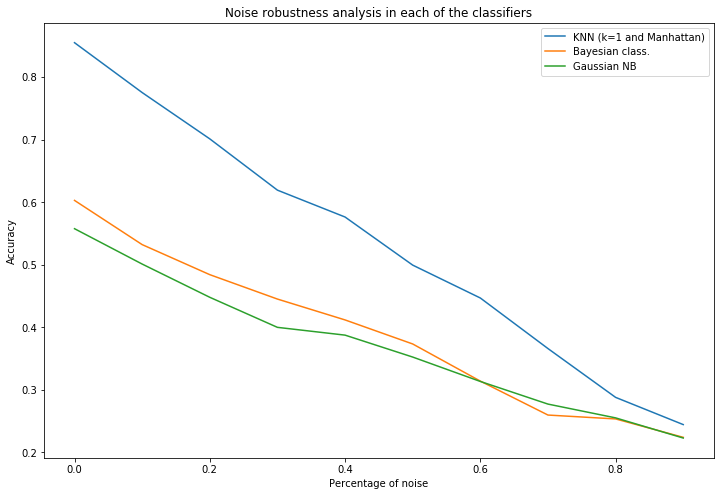

In [25]:
# Plots dos resultados de acurácia obtidos

plt.figure(figsize=(12,8))
plt.plot(np.arange(0,1,0.1),scr_knn_noise,label='KNN (k=1 and Manhattan)')
plt.plot(np.arange(0,1,0.1),scr_bc_noise,label='Bayesian class.')
plt.plot(np.arange(0,1,0.1),scr_gnb_noise,label='Gaussian NB')
plt.legend()
plt.xlabel('Percentage of noise')
plt.ylabel('Accuracy')
plt.title('Noise robustness analysis in each of the classifiers')
plt.show()

As we can see in the graph above, indeed, for this database the KNN method has a better performance than bayesian and NB classifiers. It's important to highlight that this noise analysis was conducted using gaussian NB once it showed a better performance than Bernoulli and Multinomial distribution and also because the noise distribution is spreaded by a gaussian function with mean=0 and std deviation=1.

In relation to noise robustness, we can conclued that bayesian and NB classifiers are more robust to noise than KNN, once the KNN accuracy fall as function of noise increasement was more abrupt than bayesian and NB cases.

## Training set size influence

In this last step (finally !), using the classifiers with best performance observed until now, that is KNN with manhattan metric and k=1, bayesian classifier and gaussian NB the size of training set was varied and the accuracy of the classification was monitored. The percentage of data in training set will be varied from 10% to 90% of the total amount of data.

This study has to be done in order to show how training set size influences the classification performance in KNN, bayesian and NB classifiers.

This analysis will be performed for both standardized and non-standardized data.

In [26]:

# Standardized data accuracy allocation
scr_knn_p_std=[]
scr_bc_p_std=[]
scr_gnb_p_std=[]

# Non-standardized data accuracy allocation
scr_knn_p=[]
scr_bc_p=[]
scr_gnb_p=[]

# Varying the percentage of total data that will be allocated to training set
for p in np.arange(0.2,1,0.05):
    # With standardization
    train_x_p_std, test_x_p_std, train_y_p_std, test_y_p_std = train_test_split(X_std, Y, test_size = 1-p, random_state = 42)
    # Without standardization
    train_x_p, test_x_p, train_y_p, test_y_p = train_test_split(X, Y, test_size = 1-p, random_state = 42)
    # KNN
    # With standardization
    knn.fit(train_x_p_std,train_y_p_std)
    pred_y_knn_p_std=knn.predict(test_x_p_std)
    scr_knn_p_std.append(accuracy_score(pred_y_knn_p_std,test_y_p_std))
    # Without standardization
    knn.fit(train_x_p,train_y_p)
    pred_y_knn_p=knn.predict(test_x_p)
    scr_knn_p.append(accuracy_score(pred_y_knn_p,test_y_p))
    # Bayesian classifier
    # With standardization
    pred_y_bc_p_std=bayes_classifier(train_x_p_std,train_y_p_std,test_x_p_std,classes)
    scr_bc_p_std.append(accuracy_score(pred_y_bc_p_std,test_y_p_std))
    # Without standardization
    pred_y_bc_p=bayes_classifier(train_x_p,train_y_p,test_x_p,classes)
    scr_bc_p.append(accuracy_score(pred_y_bc_p,test_y_p))
    # Gaussian Naive-Bayes
    # With standardization
    gnb.fit(train_x_p_std,train_y_p_std)
    pred_y_gnb_p_std=gnb.predict(test_x_p_std)
    scr_gnb_p_std.append(accuracy_score(pred_y_gnb_p_std,test_y_p_std))
    # Without standardization
    gnb.fit(train_x_p,train_y_p)
    pred_y_gnb_p=gnb.predict(test_x_p)
    scr_gnb_p.append(accuracy_score(pred_y_gnb_p,test_y_p))

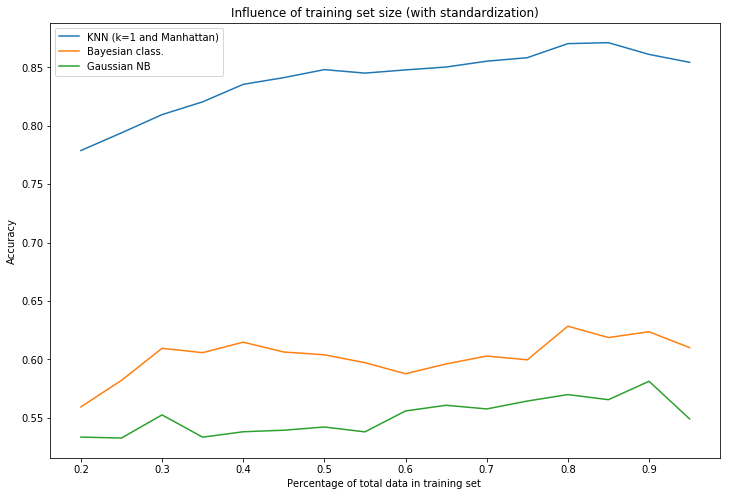

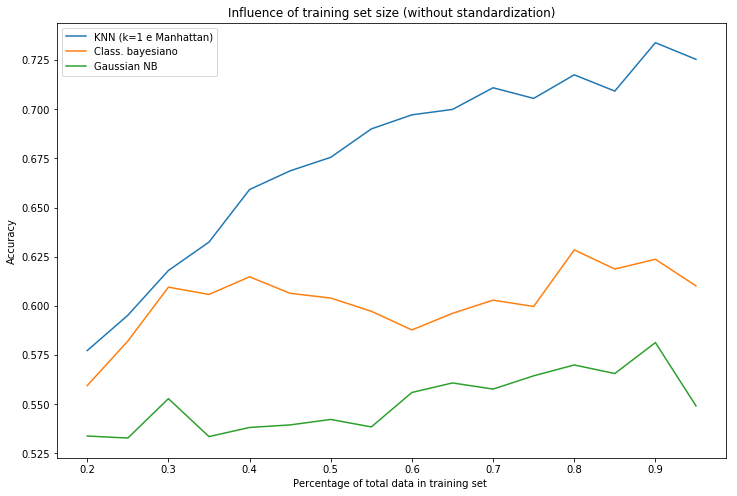

In [27]:
# Plots

plt.figure(figsize=(12,8))
plt.plot(np.arange(0.2,1,0.05),scr_knn_p_std,label='KNN (k=1 and Manhattan)')
plt.plot(np.arange(0.2,1,0.05),scr_bc_p_std,label='Bayesian class.')
plt.plot(np.arange(0.2,1,0.05),scr_gnb_p_std,label='Gaussian NB')
plt.legend()
plt.xlabel('Percentage of total data in training set ')
plt.ylabel('Accuracy')
plt.title('Influence of training set size (with standardization)')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(np.arange(0.2,1,0.05),scr_knn_p,label='KNN (k=1 e Manhattan)')
plt.plot(np.arange(0.2,1,0.05),scr_bc_p,label='Class. bayesiano')
plt.plot(np.arange(0.2,1,0.05),scr_gnb_p,label='Gaussian NB')
plt.legend()
plt.xlabel('Percentage of total data in training set ')
plt.ylabel('Accuracy')
plt.title('Influence of training set size (without standardization)')
plt.show()

Therefore, as we can see from the graph above, training sets with size bigger than 70% and smaller than 85% showed better performances, what was actually expected. In particular, in KNN, the training set with size around 80% of total data size was the one that best showed performance among all tests that were conducted until now.

This behavior was observed for both standardized and non-standardized data and non-standardized data showed worse performance, as we had already seen. This happens because features scales are very different, which makes it harder to create decisions boudaries.

## Which classifier should we choose ?

Besides the worse noise robustness, KNN with k=1 and Manhattan distance metric was the classification with best accuracy in the realized tests. Also, the removal of outliers though interquartile distance worsened a bit the KNN classification)(which will be proved once more right after).

The fact that the outliers removal worsened the KNN classification indicated that this outliers removal method also removes important data in terms of class discrimination. 

Also the standardized, without highly correlated features removal and with training set size equivalent to 81.5% of total data size were the characteristics of input data that best generated good performance in the classifications.

PS: The KNN was recreated below redundantly just for educational purposes (once the last setup of knn was with k=1 and manhattan metric).

In [32]:
# Best observed performance

p=0.815
knn=KNeighborsClassifier(n_neighbors=1, metric='manhattan')

# With outliers
train_x_final, test_x_final, train_y_final, test_y_final = train_test_split(X_std, Y, test_size = 1-p, random_state = 42)
knn.fit(train_x_final,train_y_final)
pred_y_knn_final=knn.predict(test_x_final)
scr_knn_final=accuracy_score(pred_y_knn_final,test_y_final)

# Without outliers though boxplot method
train_x_final_no_out, test_x_final_no_out, train_y_final_no_out, test_y_final_no_out = train_test_split(X_std_no_out, Y_no_out, test_size = 1-p, random_state = 42)
knn.fit(train_x_final_no_out,train_y_final_no_out)
pred_y_knn_final_no_out=knn.predict(test_x_final_no_out)
scr_knn_final_no_out=accuracy_score(pred_y_knn_final_no_out,test_y_final_no_out)

# Acurácias obtidas
print('***************************************************************************************')
print('KNN with k=1, manhattan distance, standardized data and training set size with p=',p)
print('***************************************************************************************\n')
print('Accuracy without outliers: ',scr_knn_final_no_out)
print('Accuracy with outliers: ',scr_knn_final)

***************************************************************************************
KNN with k=1, manhattan distance, standardized data and training set size with p= 0.815
***************************************************************************************

Accuracy without outliers:  0.8488805970149254
Accuracy with outliers:  0.8744271310724107
